In [7]:
# Importing libraries 

import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None) # show all columns
pd.set_option('display.max_rows', None) # show all rows
import matplotlib as plt 
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')

## Visualization
from sklearn.metrics import *
import missingno as msno

## ML
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.compose import ColumnTransformer
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


## Algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

In [8]:
# Importing the dataset 

data_raw = pd.read_csv('Customer_Churn_Data.csv', index_col='customerID')

# We'll split the data to create a train and test set, and to avoid data leakage in preprocessing 
train, test = train_test_split(data_raw, test_size=0.25)

print('Data raw: {},\n train: {},\n test: {}.'.format(data_raw.shape, train.shape, test.shape))

Data raw: (7043, 20),
 train: (5282, 20),
 test: (1761, 20).


## Initial Exploration and Descriptive Stats


In [9]:

# Look at the data and variable types - remember we set the customerID column as index, since it's very unlikely to help us

data_raw.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [10]:

# Looking at dimensionality of the data 

print('The dataset has {} rows and {} features.'.format(data_raw.shape[0], data_raw.shape[1]))
     

The dataset has 7043 rows and 20 features.


In [11]:

# Looking at the datatypes - mostly categorical variables

data_raw.dtypes
     

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [12]:
# Correct TotalCharges variable

data_raw['TotalCharges'] = pd.to_numeric(data_raw['TotalCharges'], errors='coerce')

In [13]:
# Looking at descriptive stats for the numerical variables - no weird distributions or large outliers here

data_raw.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [14]:
# What's the cardinality of our categorical variables? - No features with high cardinality

def unique_per_col(df): 
    #Selecting only categorical cols
    cols = (df.dtypes == 'object')
    object_cols = list(cols[cols].index)
    #Count unique values
    object_nunique = list(map(lambda col: df[col].nunique(), object_cols))
    d = dict(zip(object_cols, object_nunique))
    #Print number of unique entries by column, in ascending order
    for row in sorted(d.items(), key=lambda x: x[1]):
        print(row)
    
unique_per_col(data_raw)

('gender', 2)
('Partner', 2)
('Dependents', 2)
('PhoneService', 2)
('PaperlessBilling', 2)
('Churn', 2)
('MultipleLines', 3)
('InternetService', 3)
('OnlineSecurity', 3)
('OnlineBackup', 3)
('DeviceProtection', 3)
('TechSupport', 3)
('StreamingTV', 3)
('StreamingMovies', 3)
('Contract', 3)
('PaymentMethod', 4)


In [15]:
# Distribution of target variable - seems pretty balanced

data_raw['Churn'].value_counts(normalize=True)

No     0.73463
Yes    0.26537
Name: Churn, dtype: float64

,variable,Unique values,Nan %,zeros %
18,TotalCharges,6531,0.2,0.0
0,gender,2,0.0,0.0
1,SeniorCitizen,2,0.0,83.8
17,MonthlyCharges,1585,0.0,0.0
16,PaymentMethod,4,0.0,0.0
15,PaperlessBilling,2,0.0,0.0
14,Contract,3,0.0,0.0
13,StreamingMovies,3,0.0,0.0
12,StreamingTV,3,0.0,0.0
11,TechSupport,3,0.0,0.0


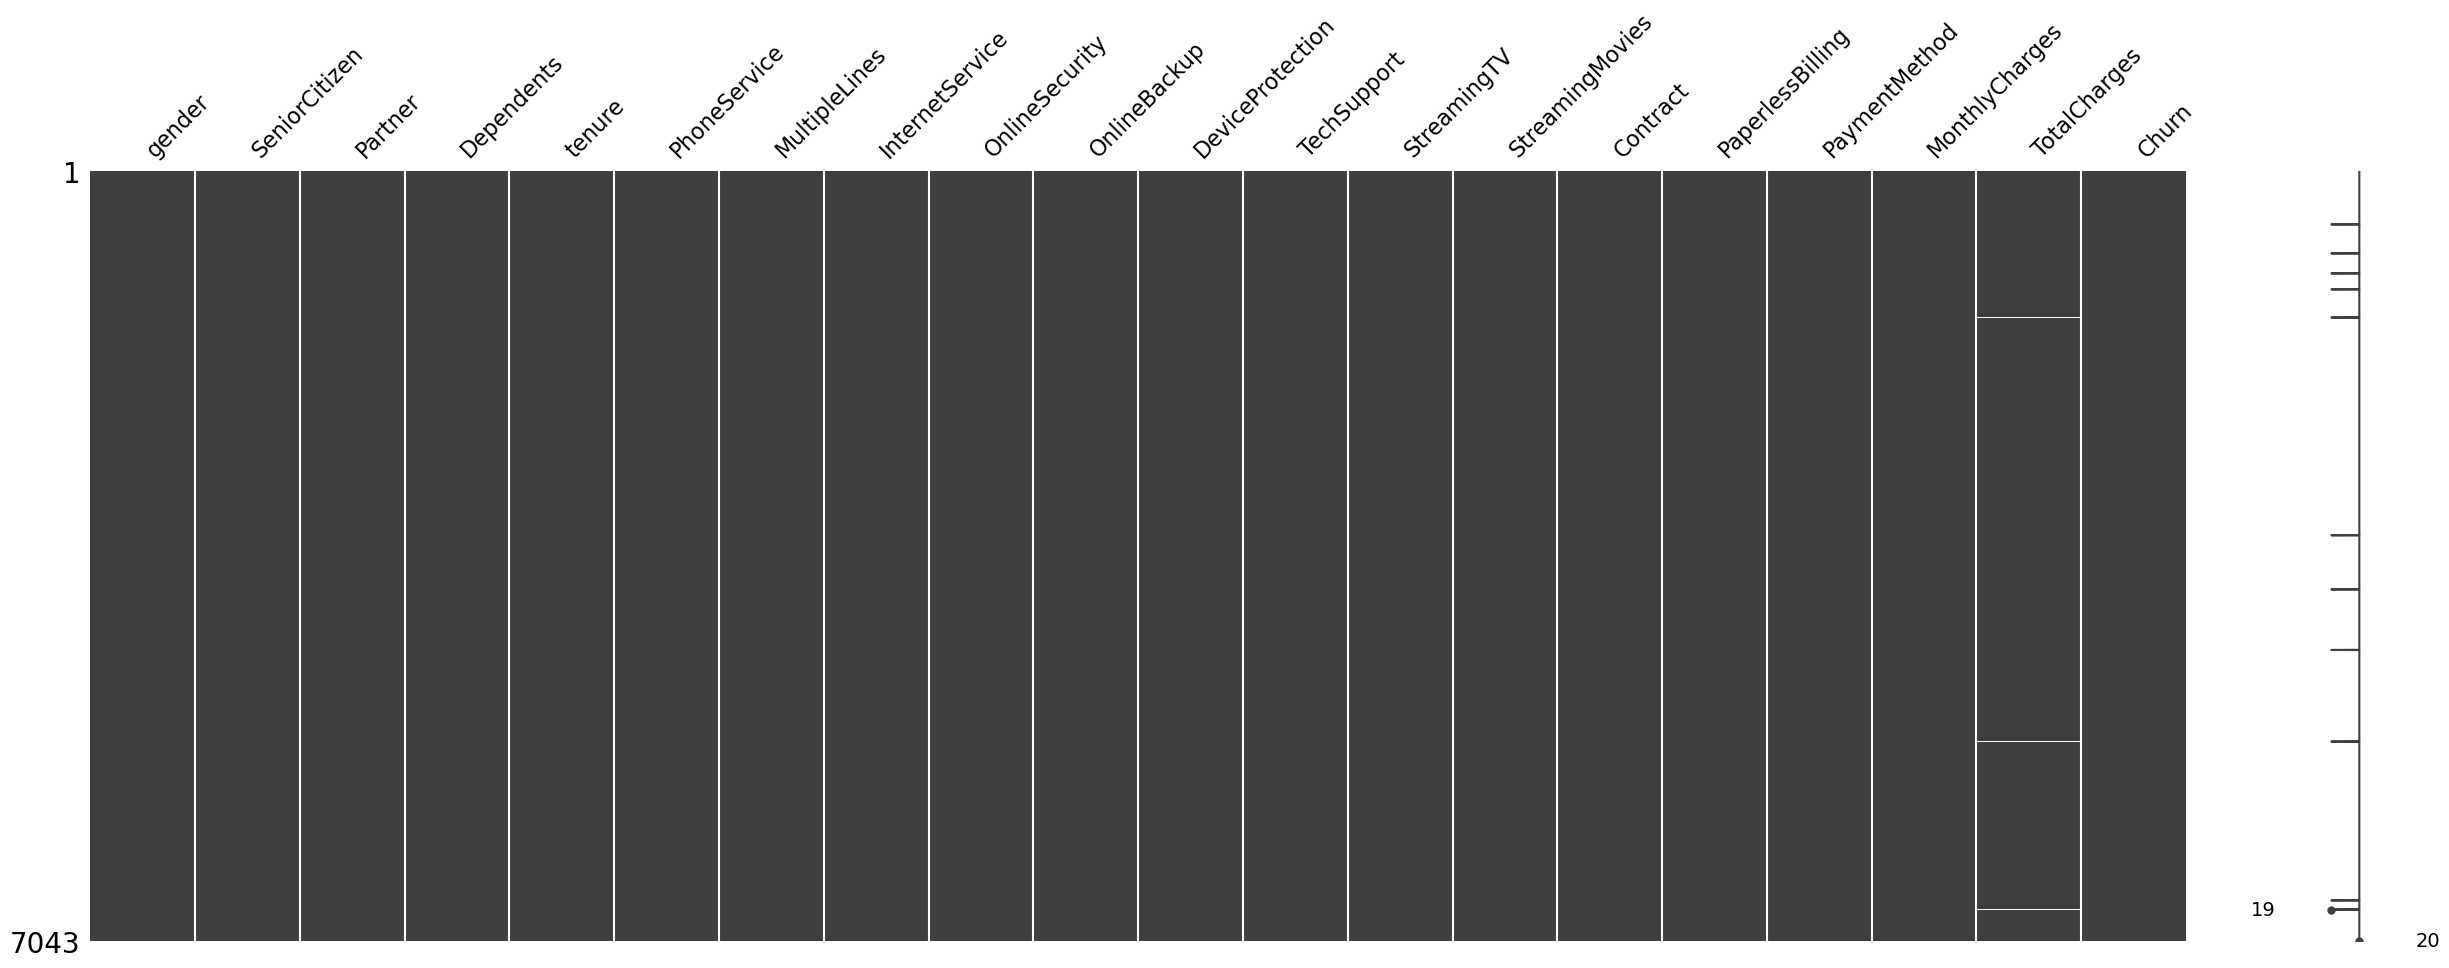

In [16]:
# Check where there's missing values

# Plot missing values for the whole dataset 

msno.matrix(data_raw, figsize = (30,10))

def missing_values(data):
    df = pd.DataFrame()
    for col in list(data):
        unique_values = data[col].unique()
        try:
            unique_values = np.sort(unique_values)
        except:
            pass
        nans = round(pd.isna(data[col]).sum()/data.shape[0]*100, 1)
        zeros = round((data[col] == 0).sum()/data.shape[0]*100, 1)
        #empty = round((data[data[col]] == '').sum()/data.shape[0]*100, 1)
        df = df.append(pd.DataFrame([col,
                                     len(unique_values),
                                     nans,
                                     zeros,
                                     #empty
                                    ]).T, ignore_index = True)

    return df.rename(columns = {0: 'variable',
                                1: 'Unique values',
                                2: 'Nan %',
                                3: 'zeros %',
                                #4: 'empty'
                               }).sort_values('Nan %', ascending=False)

missing_values(data_raw)

## Univariate Analysis


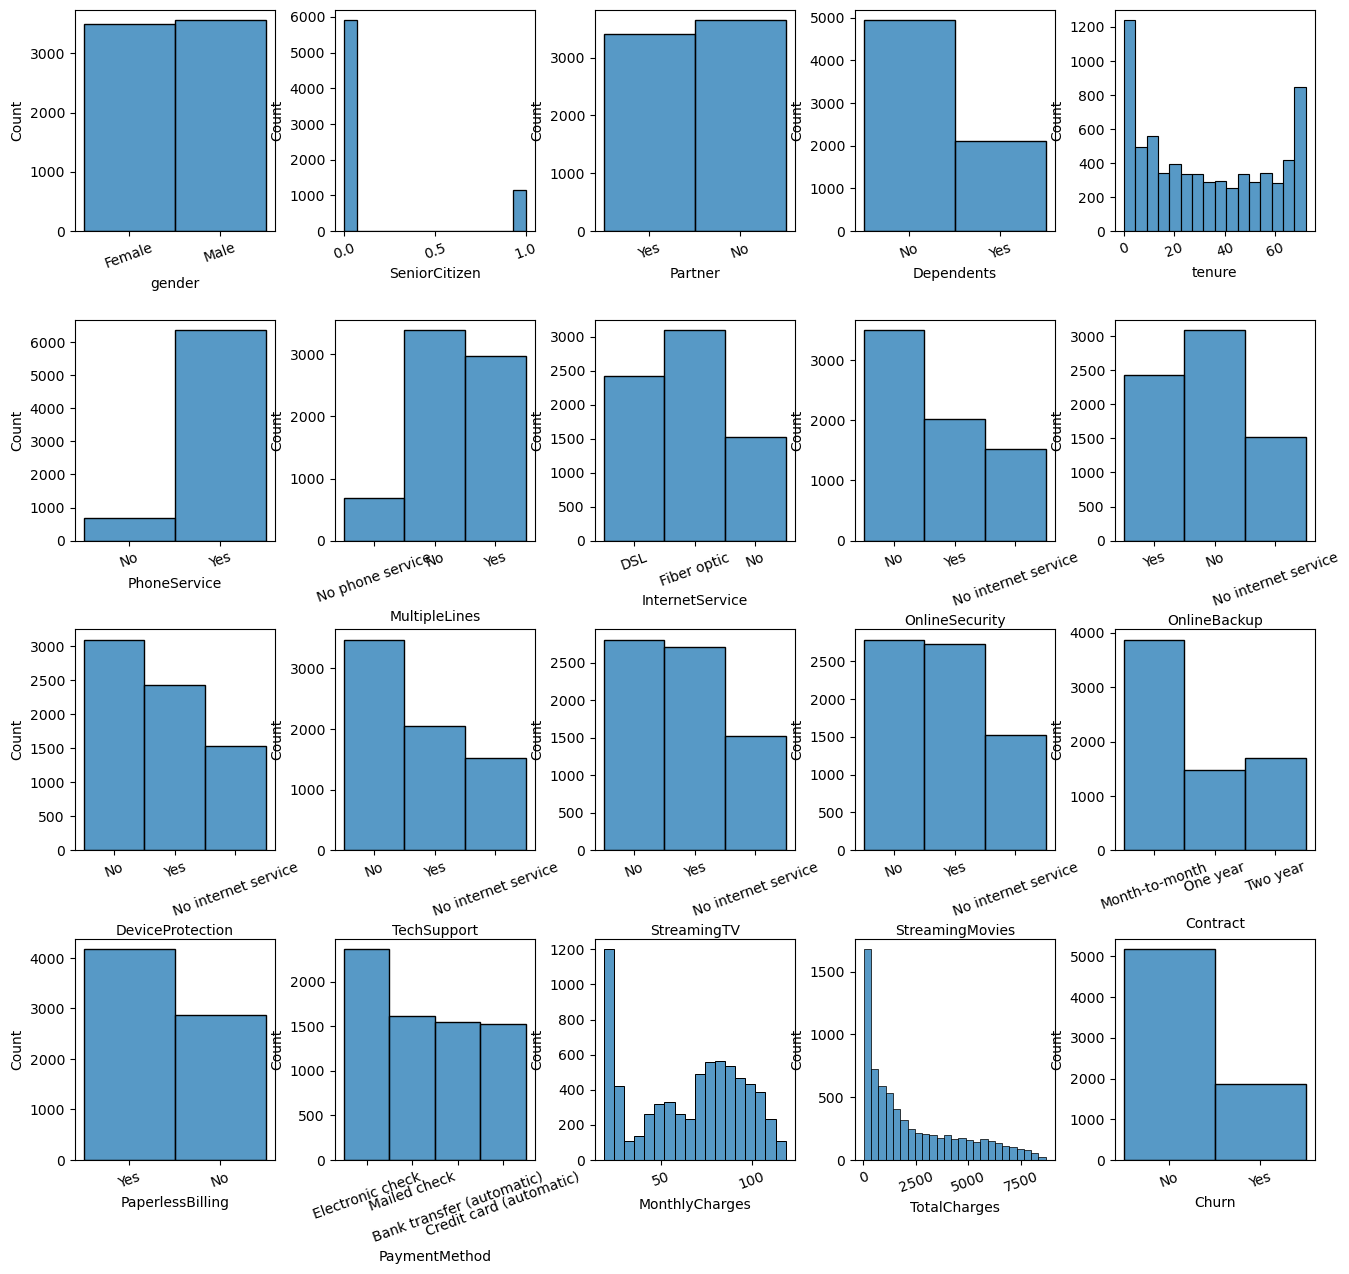

In [17]:
# Variable distributions

fig, ax = plt.subplots(4, 5, figsize=(16, 10))
plt.subplots_adjust(left=None, bottom=0.05, right=None, top=1.2, wspace=0.3, hspace=0.4)
for variable, subplot in zip(data_raw.columns, ax.flatten()):
    plot = sns.histplot(data_raw[variable], ax=subplot)
    plt.setp(plot.get_xticklabels(), rotation=20)

## Bivariate Analysis


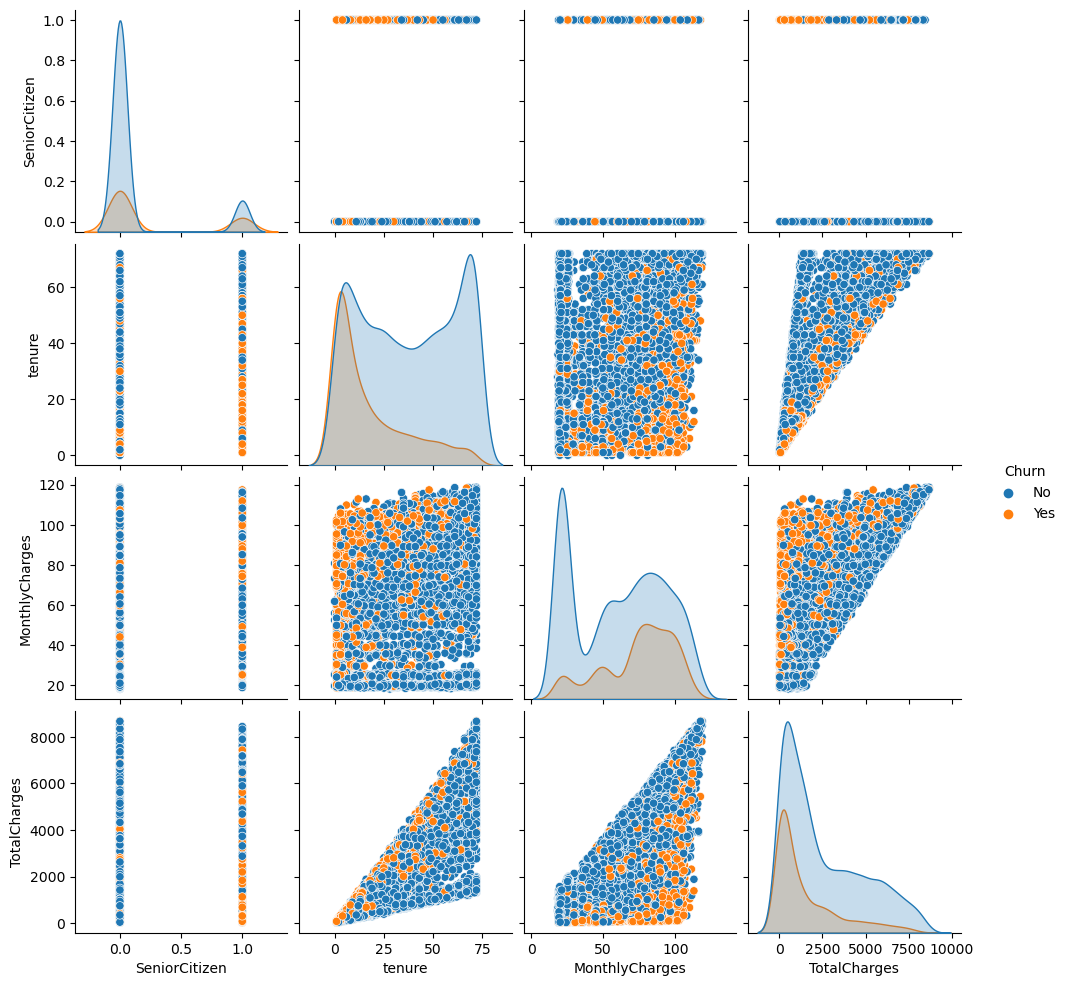

In [18]:
# Numerical-numerical variables

sns.pairplot(data = data_raw, hue='Churn')
plt.show()

In [20]:
# How many senior citizen does our dataset have anyway? 

senior_prop = round(data_raw['SeniorCitizen'].value_counts(normalize=True)[0]*100,1)
nonsenior_prop = round(data_raw['SeniorCitizen'].value_counts(normalize=True)[1]*100,1)

print('Our dataset consists of {}% non-senior citizen and {}% senior citizen.'.format(senior_prop, nonsenior_prop))


Our dataset consists of 83.8% non-senior citizen and 16.2% senior citizen.


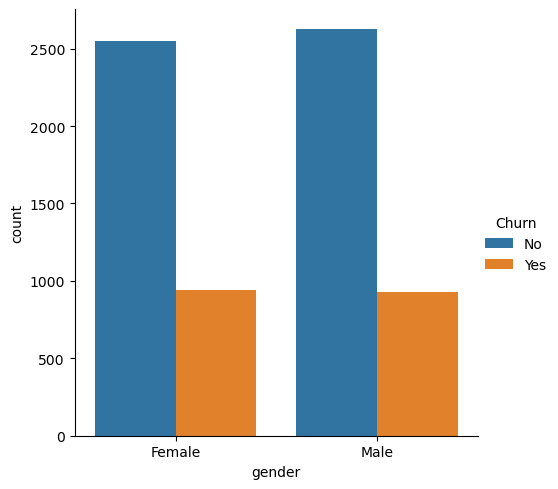

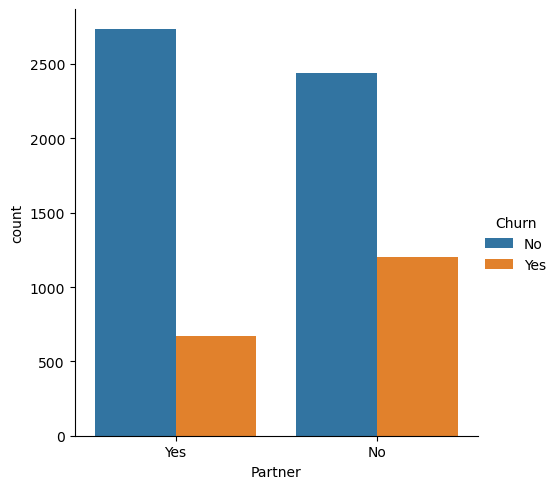

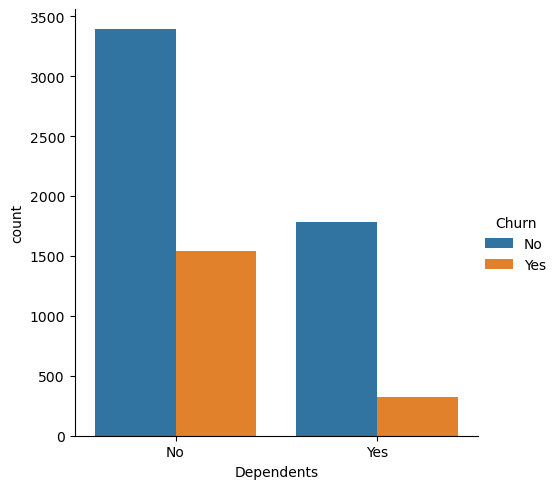

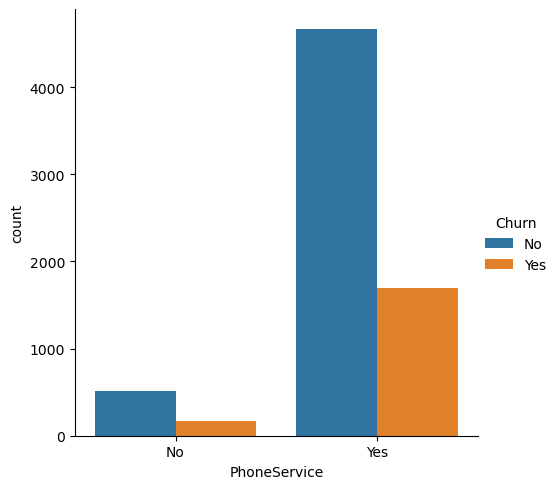

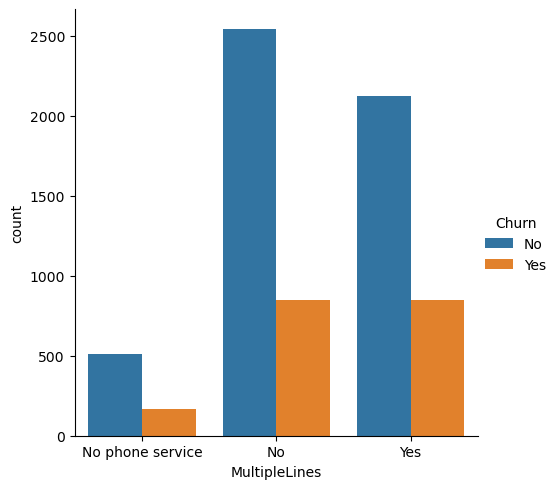

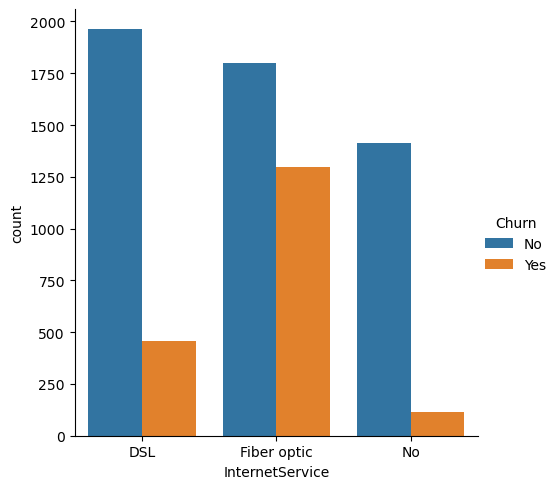

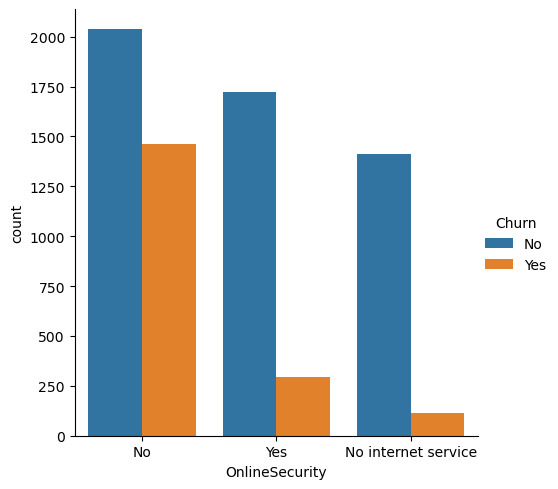

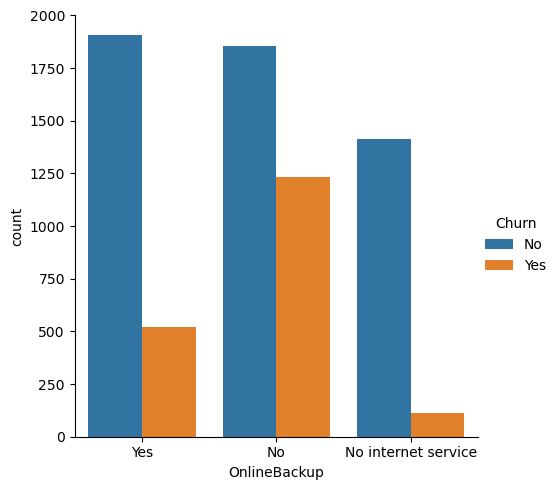

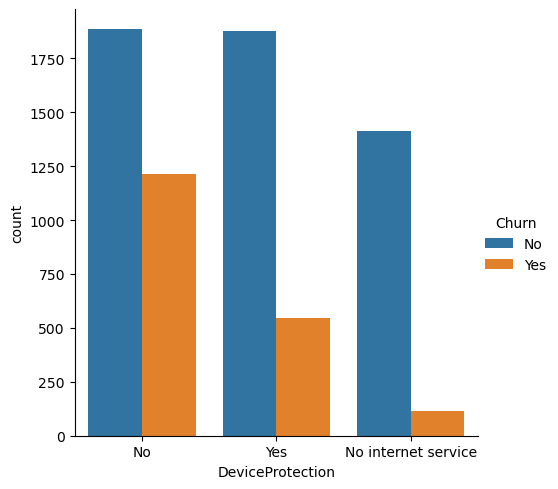

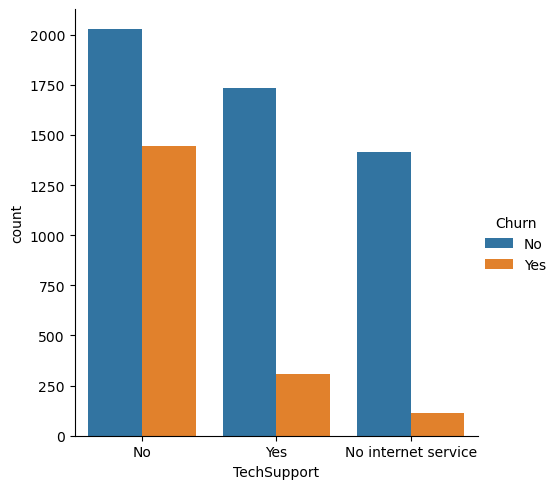

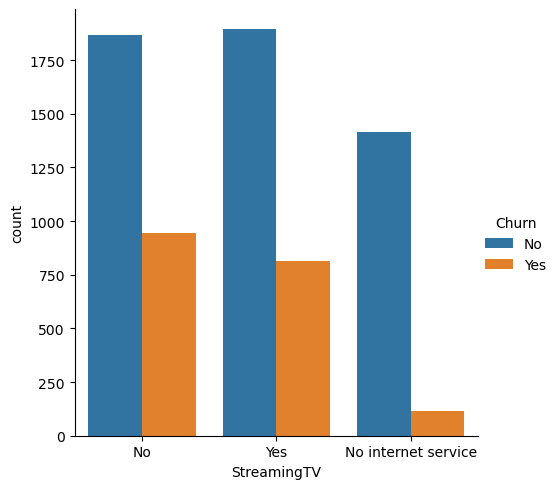

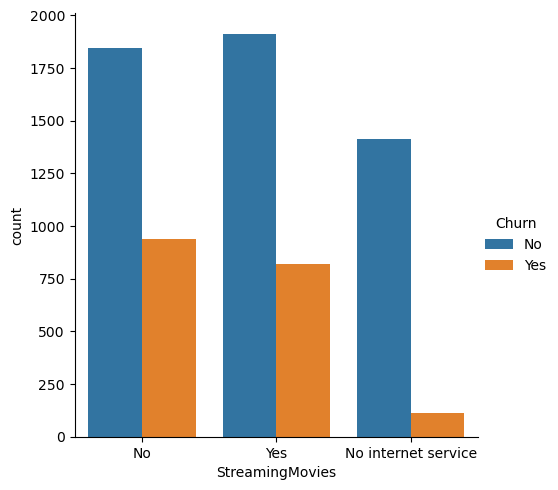

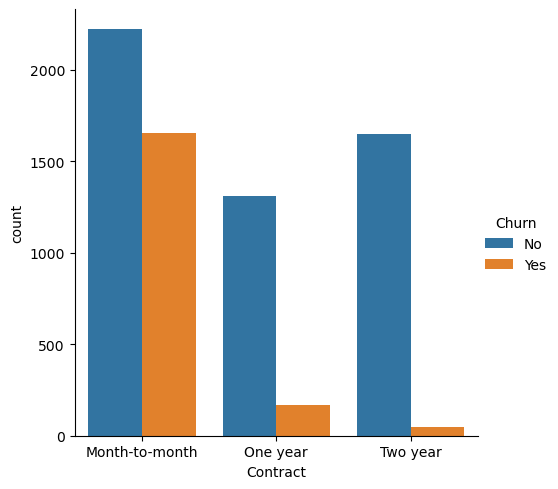

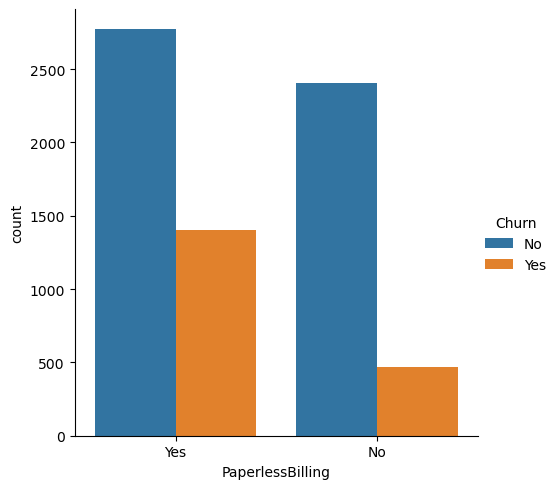

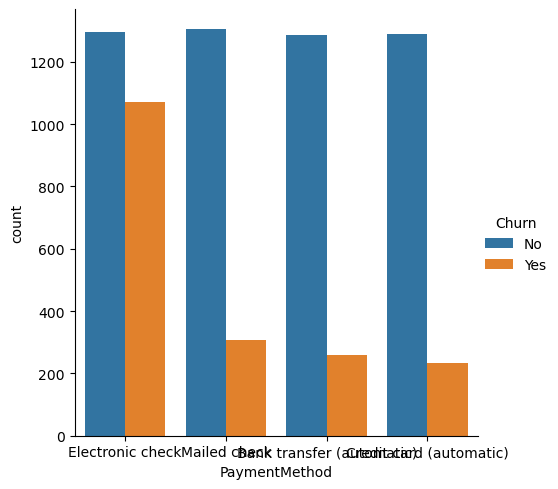

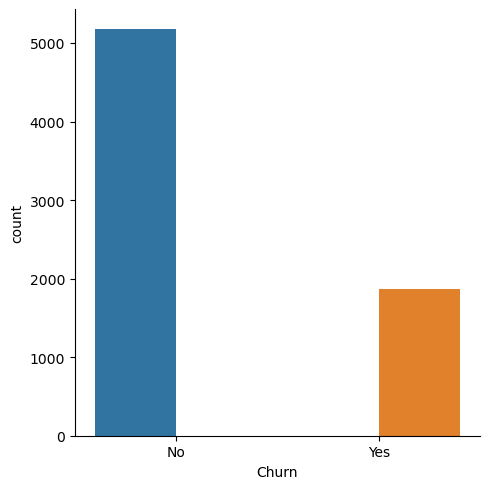

In [21]:
# Categorical-categorical variables

## How does the churn across different services look like? 
## How about the contract type? 
## Are those receiving tech support less likely to churn? 
## How about those receiving device protection less likely to churn? 

for col in data_raw.select_dtypes(exclude=np.number):
  sns.catplot(x=col, kind='count', hue='Churn', data=data_raw.select_dtypes(exclude=np.number))

## Feature Engineering and Feature Selection

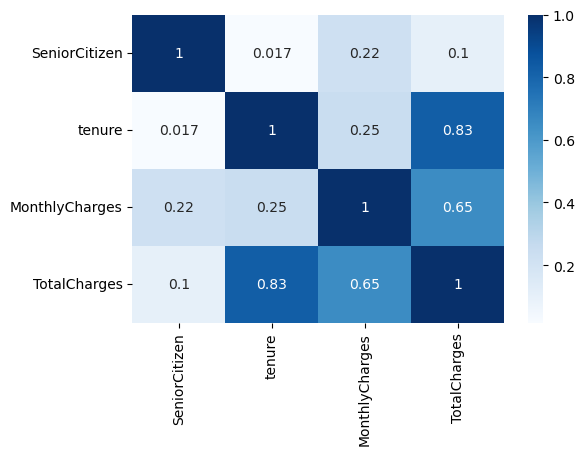

In [22]:
# Looking at multicollinearity with the feature matrix

plt.figure(figsize=(6,4))
correlations = data_raw.corr()
sns.heatmap(correlations, annot=True, cmap='Blues')
plt.show()

## Training Our Model
### Data Splitting

In [23]:
# We'll split the data to create a train and test set, and to avoid data leakage in preprocessing 
train, test = train_test_split(data_raw, test_size=0.25, random_state=123)

print('Data raw: {},\n train: {},\n test: {}.'.format(data_raw.shape, train.shape, test.shape))

Data raw: (7043, 20),
 train: (5282, 20),
 test: (1761, 20).


In [24]:
# Separate features and target in the training data 

X = train.drop(columns='Churn', axis=1)
y = train['Churn']

### Evaluation

In [25]:
# Creating a scikit learn pipeline for preprocessing

## Selecting categorical and numeric features
numerical_ix = X.select_dtypes(include=np.number).columns
categorical_ix = X.select_dtypes(exclude=np.number).columns

## Create preprocessing pipelines for each datatype 
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('encoder', OrdinalEncoder()),
    ('scaler', StandardScaler())])

## Putting the preprocessing steps together
preprocessor = ColumnTransformer([
        ('numerical', numerical_transformer, numerical_ix),
        ('categorical', categorical_transformer, categorical_ix)],
         remainder='passthrough')

### Modeling 

In [26]:
# Create example pipeline with kNN

example_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', SelectKBest(k=len(X.columns))), # keep the same amount of columns for now
    ('classifier', KNeighborsClassifier())
])

cross_val_score(example_pipe, X, y, cv=5, scoring='roc_auc').mean()
#example_pipe.fit(X_train, y_train)
#example_pipe.score(X_test, y_test)
     

0.7624360908854289

We get the highest cross-validated AUC with 0.7862 by selecting k=9.




Text(0, 0.5, 'Cross-Validated AUC')

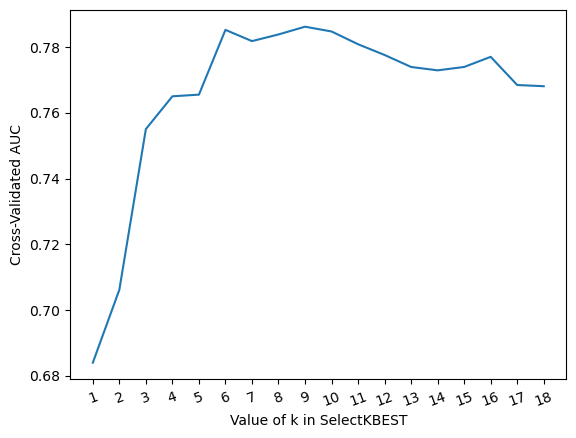

In [27]:
# Let's try the kNN but modifying the amount of features we include and compare the results

k_range = list(range(1, len(X.columns))) # 1 until 18
k_scores = []

for k in k_range:
  example_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', SelectKBest(k=k)), # keep the same amount of columns for now
    ('classifier', KNeighborsClassifier())])
  score = cross_val_score(example_pipe, X, y, cv=5, scoring='roc_auc').mean()
  k_scores.append(score)

k_scores_df = pd.DataFrame({
    'k_range': 
      k_range, 
    'k_scores':
      k_scores
})

max_value_k = np.array(k_scores_df[k_scores_df['k_scores'] == k_scores_df['k_scores'].max()])

print('We get the highest cross-validated AUC with {} by selecting k={}.\n\n'.format(round(max_value_k[0,1],4), max_value_k[0,0].astype(int)))

# Plotting the AUC across the different k values
plt.plot(k_range, k_scores)
plt.xlabel('Value of k in SelectKBEST')
plt.xticks(k_range, rotation=20) 
plt.ylabel('Cross-Validated AUC')

In [28]:
k_scores_df = pd.DataFrame({
    'Number of features': 
      k_range, 
    'k_scores':
      k_scores
})

maxValuesObj = np.array(k_scores_df[k_scores_df['k_scores'] == k_scores_df['k_scores'].max()])
k_scores_df.sort_values(by='k_scores', ascending=False)

,Number of features,k_scores
8,9,0.786181
5,6,0.785215
9,10,0.784723
7,8,0.783822
6,7,0.781797
10,11,0.780849
11,12,0.777579
15,16,0.777015
14,15,0.773937
12,13,0.773931


#### Model Selection

In [29]:
# Trying out different classifiers and selecting the best

## Creat list of classifiers we're going to loop through
classifiers = [
    KNeighborsClassifier(),
    SVC(random_state=123),
    DecisionTreeClassifier(random_state=123),
    RandomForestClassifier(random_state=123),
    AdaBoostClassifier(random_state=123),
    GradientBoostingClassifier(random_state=123)
    ]

classifier_names = [
    'KNeighborsClassifier()',
    'SVC()',
    'DecisionTreeClassifier()',
    'RandomForestClassifier()',
    'AdaBoostClassifier()',
    'GradientBoostingClassifier()'
]

model_scores = []

## Looping through the classifiers
for classifier, name in zip(classifiers, classifier_names):
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('selector', SelectKBest(k=len(X.columns))),
        ('classifier', classifier)])
    score = cross_val_score(pipe, X, y, cv=10, scoring='roc_auc').mean() # we're using the AUC here!
    model_scores.append(score)
    print("Model score for {}: {}".format(name, score))


Model score for KNeighborsClassifier(): 0.7611951183202572
Model score for SVC(): 0.8016581799333506
Model score for DecisionTreeClassifier(): 0.658419086454004
Model score for RandomForestClassifier(): 0.8243600923390618
Model score for AdaBoostClassifier(): 0.8463012180435487
Model score for GradientBoostingClassifier(): 0.8463252152654143


#### Comparing the algorithms

Text(0, 0.5, 'Cross-Validated AUC')

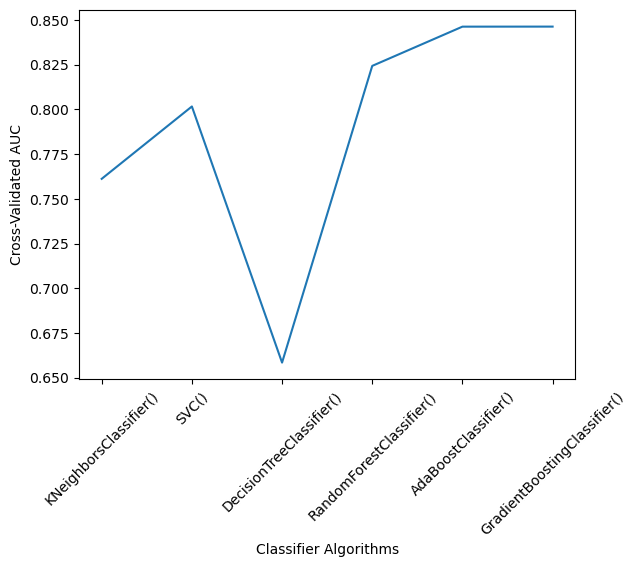

In [30]:
# Plotting models and performance

plt.plot(classifier_names, model_scores)
plt.xlabel('Classifier Algorithms')
plt.xticks(classifier_names, rotation=45) 
plt.ylabel('Cross-Validated AUC')
     

In [31]:
# Creating df with model performance

model_performance = pd.DataFrame({
    'Classifier': 
      classifier_names, 
    'Cross-validated AUC':
      model_scores
})

## Sorting in descending manner
sorted_models = model_performance.sort_values('Cross-validated AUC', ascending = False, ignore_index=True)
display(sorted_models)
## Extracting best performing model and saving it for the following step 
best_model = eval(sorted_models['Classifier'][0]) # we use eval(), because otherwise we get a string instead of the algorithm class


,Classifier,Cross-validated AUC
0,GradientBoostingClassifier(),0.846325
1,AdaBoostClassifier(),0.846301
2,RandomForestClassifier(),0.824360
3,SVC(),0.801658
4,KNeighborsClassifier(),0.761195
5,DecisionTreeClassifier(),0.658419


## Test the Model

In [41]:
# Corrected import for plot_roc_curve

# Separate features and target in the test data
X_test = test.drop(columns='Churn', axis=1)
y_test = test['Churn']

# Creating the predictions and prediction scores
y_pred = final_model.predict(X_test)
y_score = final_model.predict_proba(X_test)[:, 1]  # Probability of the positive class

# Looking at the performance
from sklearn.metrics import roc_auc_score, accuracy_score

print('AUCROC:', roc_auc_score(y_test, y_score), '\nAccuracy:', accuracy_score(y_test, y_pred))


AUCROC: 0.8410315083415643 
Accuracy: 0.7915956842703009
